<a ><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/Logo_INSA_Lyon_%282014%29.svg/langfr-2560px-Logo_INSA_Lyon_%282014%29.svg.png"  width="200" align="left"> </a>
<div style="text-align: right"> <h3><span style="color:gray"> Projet de recherche </span> </h3> </div>

<br>
<br>
<br>


<h1><center>Model Building</center></h1>
<h2><center> <span style="font-weight:normal"><font color='#e42618'>Creating classifiers based on Large Language Models (LLMs) to improve predictions</font>  </span></center></h2>
<h3><center><font color='gray'>JONAS GOTTAL</font></center></h3>


<h4>Project scope</h4>

- Obtaining financial research containing both a report in natural language and a quantifiable prediction on the underlying asset
- Building predictive models that e.g., accurately detect semantic causality
- Evaluation whether there is a correlation between causal formulations and a higher accuracy from an analyst
<br>

---
---

## ToDo Saturday

### Prio 4 
- ~~Create a Classifier based on Texts (Bull/Bear/Analyst Note) ~~
    - ~~Classification of prediction based on Bear / Bull / Analyst Note~~
    - ~~Classification of actual Trend based on Bear / Bull / Analyst Note~~
    - ~~Compare confidence between Bull/Bear classifications~~
    - ~~Given the confidence in Bull/Bear predictions, is there a correlation between the actual prediction?~~

### Prio 5
- Finalize Report
- Run Scraper and add data

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="text-decoration:none; margin-top: 30px; background-color:#F2F2F2; border-color:#720006">
    <span style="color:#720006">
    <ol>
        <li><a href="#1"> <span style="color:#720006;text-decoration:underline;text-decoration-color:#F2F2F2" 
       >Model scope and pipeline selection</span> </a></li>
       <li><a href="#5"> <span style="color:#720006;text-decoration:underline;text-decoration-color:#F2F2F2" 
       >Large Language Models (LLMs) as classifiers</span> </a></li> 
       <ol>
       <li><a href="#6"> <span style="color:#720006;text-decoration:underline;text-decoration-color:#F2F2F2" 
       >The authors prediction</span> </a></li>
       <li><a href="#7"> <span style="color:#720006;text-decoration:underline;text-decoration-color:#F2F2F2" 
       >The actual trend</span> </a></li>
       <li><a href="#8"> <span style="color:#720006;text-decoration:underline;text-decoration-color:#F2F2F2" 
       >Confidence as basis of correlation</span> </a></li>
       </ol>
       <li><a href="#10"> <span style="color:#720006;text-decoration:underline;text-decoration-color:#F2F2F2" 
       >Preliminary Conclusion</span> </a></li>
    </ol>
    </span>
</div>

#### Requirements
- ```Python 3.9.18``` (conda env)
- ```pip freeze > requirements.txt```
- ```conda env export > environment.yml```

# Model scope and pipeline selection <a id="1"></a>

Our goal is to design a pipeline that classifies both the analysts predictions and the actual trend in a efficient way without sacrificing the opportunity to easily change the underlying language model or return the models confidence in the label. This is why we choose ```KerasNLP```.

### Load Data and packages

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import keras_nlp
from sklearn.model_selection import train_test_split
import json
from sklearn.metrics import roc_curve, auc
from keras.metrics import AUC
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')



df = pd.read_csv('Data/final_data.csv', index_col=0)
df = df[df["IsClose"] == True]
# then reset index
df = df.reset_index(drop=True)


with open('Data/Market Data/30d_data/JSON/all_data.json') as f:
    all_data_60 = json.load(f)

# Convert each item in the dictionary back into a DataFrame
all_data_60_df = {key: pd.read_json(value, orient='columns') for key, value in all_data_60.items()}

#the prediction is for a longer time horizon, so we can be less precise (6%)
def isclose(a, b, rel_tol=6e-02, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

# we loop over i elements in the df and check whether the price is within 5% of the price in the Price column
prediction_list = []
value = False
for i in range(len(df)):
    value = isclose(df["FairPrice"][i], df["Price"][i])
    if value == True:
        prediction_list.append(0)
    else:
        if df["FairPrice"][i] > df["Price"][i]:
            prediction_list.append(1)
        else:
            prediction_list.append(0)
    # print progress
    #print(f"{i+1}/{len(df)}")

df["Prediction"] = prediction_list


df["60dAvgPriceBefore"] = np.nan
df["60dAvgPriceAfter"] = np.nan
#the actual is for a shorter time horizon, so we have to be more precise (2%)
def isclose(a, b, rel_tol=2e-02, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

for i in range(len(df)):
    symbol = df["FinalTickerSymbol"][i]
    date = df["PriceDate"][i]
    # turn date into datetime
    date = datetime.strptime(date, '%d/%m/%Y')
    date = date.strftime('%Y-%m-%d')
    try:
        df["60dAvgPriceBefore"][i] = all_data_60_df[symbol]["Adj Close"][:date].mean()
        df["60dAvgPriceAfter"][i] = all_data_60_df[symbol]["Adj Close"][date:].mean()
    except:
        pass
    # print progress
    print(f"{i+1}/{len(df)}")

trend_list = []
value = False
for i in range(len(df)):
    value = isclose(df["60dAvgPriceAfter"][i], df["TickerPrice"][i])
    if value == True:
        trend_list.append(0)
    else:
        if df["TickerPrice"][i] < df["60dAvgPriceAfter"][i]:
            trend_list.append(1)
        else:
            trend_list.append(0)
    # print progress
    print(f"{i+1}/{len(df)}")

df["Actual"] = trend_list


2024-01-23 14:55:37.095365: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend
1/1586
2/1586
3/1586
4/1586
5/1586
6/1586
7/1586
8/1586
9/1586
10/1586
11/1586
12/1586
13/1586
14/1586
15/1586
16/1586
17/1586
18/1586
19/1586
20/1586
21/1586
22/1586
23/1586
24/1586
25/1586
26/1586
27/1586
28/1586
29/1586
30/1586
31/1586
32/1586
33/1586
34/1586
35/1586
36/1586
37/1586
38/1586
39/1586
40/1586
41/1586
42/1586
43/1586
44/1586
45/1586
46/1586
47/1586
48/1586
49/1586
50/1586
51/1586
52/1586
53/1586
54/1586
55/1586
56/1586
57/1586
58/1586
59/1586
60/1586
61/1586
62/1586
63/1586
64/1586
65/1586
66/1586
67/1586
68/1586
69/1586
70/1586
71/1586
72/1586
73/1586
74/1586
75/1586
76/1586
77/1586
78/1586
79/1586
80/1586
81/1586
82/1586
83/1586
84/1586
85/1586
86/1586
87/1586
88/1586
89/1586
90/1586
91/1586
92/1586
93/1586
94/1586
95/1586
96/1586
97/1586
98/1586
99/1586
100/1586
101/1586
102/1586
103/1586
104/1586
105/1586
106/1586
107/1586
108/1586
109/1586
110/1586
111/1586
112/1586
113/1586
114/1586
115/1586
116/1586
117/1586
118/1586
119/1586
120/1586
121

We check whether the stock is growing ```(1)```, constant or falling ```(0)``` .

In [2]:
df.head()


,ParseDate,Title,CompanyName,TickerSymbol,Rating,ReportDate,AuthorName,Price,Currency,PriceDate,...,MarketCap,Exchange,Volume,TickerCurrency,TickerPrice,IsClose,Prediction,60dAvgPriceBefore,60dAvgPriceAfter,Actual
0,24/11/2023,Virgin Money Meeting Short-Term Targets but Me...,Virgin Money UK PLC,VMUK,4,24/11/2023,Nathan Zaia,146.75,GBP,23/11/2023,...,1.932661e+09,LSE,45564.0,GBp,157.000000,True,1,157.710417,154.075000,0
1,24/11/2023,Virgin Money Meeting Short-Term Targets but Me...,Virgin Money UK PLC,VUK,4,24/11/2023,Nathan Zaia,2.78,AUD,24/11/2023,...,3.709752e+09,ASX,2057263.0,AUD,2.960000,True,1,2.994167,2.940476,0
2,24/11/2023,Qube's Good Momentum Likely to Carry Into Fisc...,Qube Holdings Ltd,QUB,4,24/11/2023,Adrian Atkins,2.93,AUD,24/11/2023,...,5.229462e+09,ASX,2520549.0,AUD,2.930000,True,1,2.840000,3.059524,1
3,24/11/2023,Stabilization of Political Risk in Spain Is Po...,Endesa SA,ELE,4,23/11/2023,Tancrede Fulop,18.84,EUR,24/11/2023,...,2.130355e+10,IOB,5925.0,EUR,18.764191,True,1,18.198966,18.992456,0
4,24/11/2023,Sage Has Reached an Inflection Point in Its Cl...,Sage Group (The) PLC,SGE,1,23/11/2023,Rob Hales,1130.50,GBP,23/11/2023,...,1.173311e+10,LSE,262362.0,GBp,1130.000000,True,0,980.521973,1142.985268,0


# Large Language Models (LLMs) as classifiers <a id="5"></a>

We use a very small model for the testing phase:

In [3]:
model_name = "bert_tiny_en_uncased_sst2"

## The authors prediction <a id="6"></a> 


In [4]:
# Use the subset of df with BearsList and BullsList and AnalystNoteList and Prediction
df = df[['BearsList','BullsList','AnalystNoteList','Prediction', 'Actual']]
# drop NA values from df first
df = df.dropna()
# split into train and test sets
X = df[['BearsList','BullsList','AnalystNoteList', 'Prediction']]
y = df['Prediction']

# set random state for train_test_split
X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = 0.20, random_state=0)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=2, dtype='float32')
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2, dtype='float32')

legend_names = ['Bulls and Bear List', 'Analyst Note List']
X_list_train = [X_train['BullsList']+ X_train['BearsList'], X_train['AnalystNoteList']]
X_list_test = [X_test['BullsList']+ X_test['BearsList'], X_test['AnalystNoteList']]

We have an uneven distribution between our labels! So accuracy is not a metric we should use.

<Axes: >

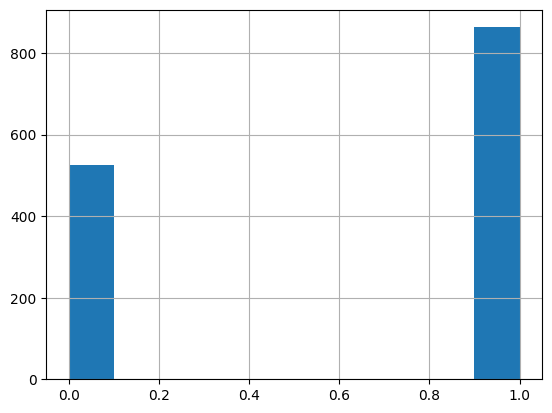

In [5]:
y.hist()

2024-01-23 14:56:18.325206: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa2b2931340 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-01-23 14:56:18.325240: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-01-23 14:56:18.325738: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-23 14:56:18.637749: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-23 14:56:18.986664: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.st

9/9 [==============================] - 8s 605ms/step


9/9 [==============================] - 8s 590ms/step


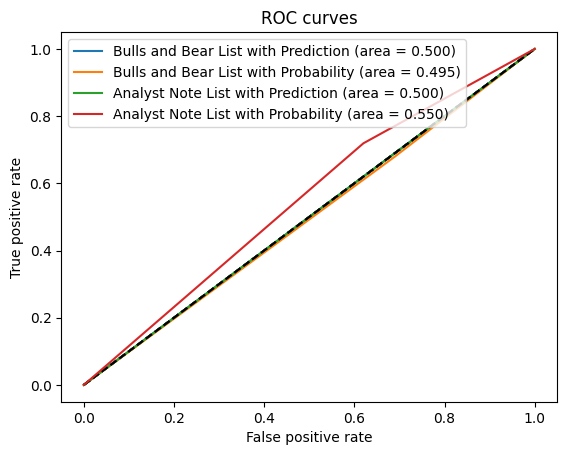

In [6]:
plt.figure()

for i in range(len(legend_names)):
    
    X_test = X_list_test[i]
    X_train = X_list_train[i]
    # Pretrained classifier.
    classifier = keras_nlp.models.BertClassifier.from_preset(
        model_name,
        num_classes=2,
        load_weights = True,
        activation='sigmoid'
    )
    classifier.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    jit_compile=True,
        metrics=[AUC()],
    )
    # Access backbone programatically (e.g., to change `trainable`).
    classifier.backbone.trainable = False
    # Fit again.
    classifier.fit(x=X_train, y=y_train, validation_data=(X_test,y_test), batch_size=32)
    y_pred_keras = classifier.predict(X_test)
    y_pred_labels = y_pred_keras.argmax(axis=-1)

    # The model always predicts 1, so we need to calculate the average of the predictions
    average_0 = sum(sublist[0] for sublist in y_pred_keras) / len(y_pred_keras)
    average_1 = sum(sublist[1] for sublist in y_pred_keras) / len(y_pred_keras)

    # construct a numpy.ndarray of labels by deciding whether the first element of the sublist is above or below average
    avg_labels = []
    for sublist in y_pred_keras:
        if sublist[1] < average_1 and sublist[0] > average_0:
            avg_labels.append(0)
        else:
            avg_labels.append(1)
    # turn list in numpy.ndarray
    avg_labels = np.array(avg_labels)

    y_test_labels = y_test.argmax(axis=-1)
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_labels, y_pred_labels)
    auc_keras = auc(fpr_keras, tpr_keras)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label= legend_names[i] +  ' with Prediction (area = {:.3f})'.format(auc_keras))

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_labels, avg_labels)
    auc_keras = auc(fpr_keras, tpr_keras)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label= legend_names[i] +  ' with Probability (area = {:.3f})'.format(auc_keras))

    
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves')
plt.legend(loc='best')
# save the plot as pdf
plt.savefig('Plots/ROC_curves_prediction.pdf')
plt.show()




In [7]:
print(list(X_test)[10])
class_names = ["Bear","Bull"]
scores = classifier.predict([list(X_test)[10]])
scores
f"{class_names[np.argmax(scores)]} with a { (100 * np.max(scores)).round(2) } percent confidence."

Wide-moat Northern Trust reported a mostly in-line third quarter. Revenue of $1.74 billion and EPS of $1.49 were roughly consistent with the FactSet estimates of $1.74 billion and $1.50. Net interest income continues to decline and offers limited visibility, a factor weighing on the stock. Still, we think investors should not overreact to a volatile revenue item; we believe the firms wealth-management franchise continues to hold up. As a result, we are maintaining our $86 fair value estimate and believe the shares are attractive. Net interest income was down 10% sequentially, with the 1.41% GAAP net interest margin in line with our expectations. Northern Trust expects fourth-quarter net interest income to be down 7% at the midpoint, a result below our and Street expectations. Unlike State Street, Northern Trust did not quantify its 2024 net interest income expectations, saying there is a wide range of outcomesa view likely frustrating investors. Asset servicing trust fee revenue was up

'Bull with a 62.8 percent confidence.'

## The actual trend <a id="7"></a> 

In [8]:
# split into train and test sets
X = df[['BearsList','BullsList','AnalystNoteList', 'Prediction']]
y = df['Actual']

# set random state for train_test_split;
X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = 0.20, random_state=0)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=2, dtype='float32')
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2, dtype='float32')

legend_names = ['Bulls and Bear List', 'Analyst Note List']
X_list_train = [X_train['BullsList']+ X_train['BearsList'], X_train['AnalystNoteList']]
X_list_test = [X_test['BullsList']+ X_test['BearsList'], X_test['AnalystNoteList']]
X_baseline_train = X_train['Prediction']
X_baseline_test = X_test['Prediction']

We have an uneven distribution between our labels! So accuracy is not a metric we should use.

<Axes: >

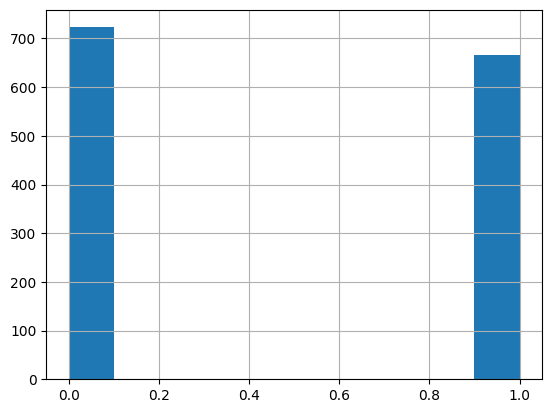

In [9]:
y.hist()

9/9 [==============================] - 8s 607ms/step


9/9 [==============================] - 9s 682ms/step


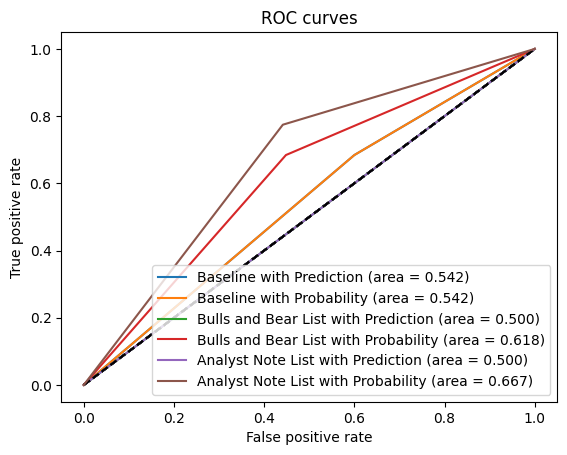

In [10]:
plt.figure()
# Baseline
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(X_baseline_train.values.reshape(-1, 1), y_train)

y_pred_keras = rf.predict(X_baseline_test.values.reshape(-1, 1))
y_pred_labels = y_pred_keras.argmax(axis=-1)


# The model always predicts 1, so we need to calculate the average of the predictions
average_0 = sum(sublist[0] for sublist in y_pred_keras) / len(y_pred_keras)
average_1 = sum(sublist[1] for sublist in y_pred_keras) / len(y_pred_keras)

# construct a numpy.ndarray of labels by deciding whether the first element of the sublist is above or below average
avg_labels = []
for sublist in y_pred_keras:
    if sublist[1] < average_1 and sublist[0] > average_0:
        avg_labels.append(0)
    else:
        avg_labels.append(1)
# turn list in numpy.ndarray
avg_labels = np.array(avg_labels)

y_test_labels = y_test.argmax(axis=-1)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_labels, y_pred_labels)
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label=  'Baseline with Prediction (area = {:.3f})'.format(auc_keras))

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_labels, avg_labels)
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label= 'Baseline with Probability (area = {:.3f})'.format(auc_keras))

for i in range(len(legend_names)):
    
    X_test = X_list_test[i]
    X_train = X_list_train[i]
    # Pretrained classifier.
    classifier = keras_nlp.models.BertClassifier.from_preset(
        model_name,
        num_classes=2,
        load_weights = True,
        activation='sigmoid'
    )
    classifier.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    jit_compile=True,
        metrics=[AUC()],
    )
    # Access backbone programatically (e.g., to change `trainable`).
    classifier.backbone.trainable = False
    # Fit again.
    classifier.fit(x=X_train, y=y_train, validation_data=(X_test,y_test), batch_size=32)
    y_pred_keras = classifier.predict(X_test)
    y_pred_labels = y_pred_keras.argmax(axis=-1)

    # The model always predicts 1, so we need to calculate the average of the predictions
    average_0 = sum(sublist[0] for sublist in y_pred_keras) / len(y_pred_keras)
    average_1 = sum(sublist[1] for sublist in y_pred_keras) / len(y_pred_keras)

    # construct a numpy.ndarray of labels by deciding whether the first element of the sublist is above or below average
    avg_labels = []
    for sublist in y_pred_keras:
        if sublist[1] < average_1 and sublist[0] > average_0:
            avg_labels.append(0)
        else:
            avg_labels.append(1)
    # turn list in numpy.ndarray
    avg_labels = np.array(avg_labels)

    y_test_labels = y_test.argmax(axis=-1)
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_labels, y_pred_labels)
    auc_keras = auc(fpr_keras, tpr_keras)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label= legend_names[i] +  ' with Prediction (area = {:.3f})'.format(auc_keras))

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_labels, avg_labels)
    auc_keras = auc(fpr_keras, tpr_keras)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label= legend_names[i] +  ' with Probability (area = {:.3f})'.format(auc_keras))


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves')
plt.legend(loc='best')
# save the plot as pdf
plt.savefig('Plots/ROC_curves_actual.pdf')
plt.show()


## Confidence as basis of correlation <a id="8"></a> 

This approach shows that the classifier always chooses one label since they are not distributed evenly. This leads to an AUC of 0.5 (pure randomness). But if we use the confidence in the predictions as a measure and re-assign labels based on Above or Below average, we can actually make good predictions - especially for the actual trend.
Let's refine our approach:

(array([111.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 167.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

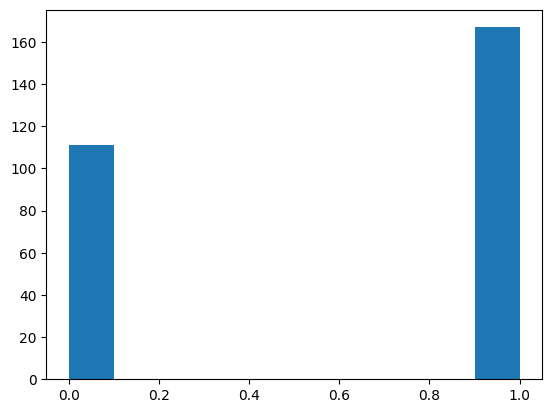

In [11]:
#plot histogram of np array
plt.hist(avg_labels)

We have a strong tendency to predict 1, while the actual trend is closer to an even distribution.
We can redesign our ```avg_labels```

9/9 [==============================] - 9s 709ms/step


9/9 [==============================] - 9s 670ms/step


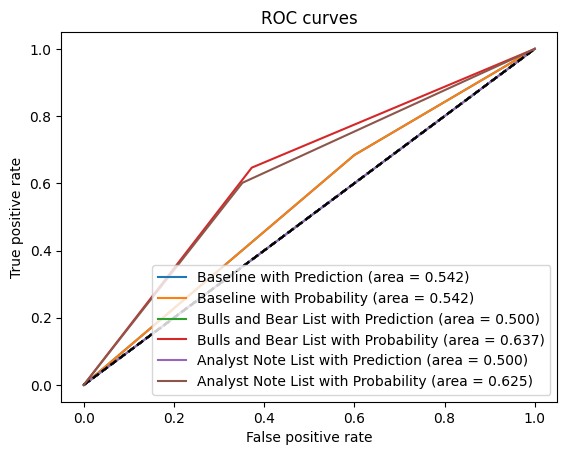

In [12]:
plt.figure()
# Baseline
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(X_baseline_train.values.reshape(-1, 1), y_train)

y_pred_keras = rf.predict(X_baseline_test.values.reshape(-1, 1))
y_pred_labels = y_pred_keras.argmax(axis=-1)


# The model always predicts 1, so we need to calculate the average of the predictions
average_0 = sum(sublist[0] for sublist in y_pred_keras) / len(y_pred_keras)
average_1 = sum(sublist[1] for sublist in y_pred_keras) / len(y_pred_keras)

# construct a numpy.ndarray of labels by deciding whether the first element of the sublist is above or below average
avg_labels = []
for sublist in y_pred_keras:
    if sublist[1] > average_1 and sublist[0] < average_0:
        avg_labels.append(1)
    else:
        avg_labels.append(0)
# turn list in numpy.ndarray
avg_labels = np.array(avg_labels)

y_test_labels = y_test.argmax(axis=-1)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_labels, y_pred_labels)
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label=  'Baseline with Prediction (area = {:.3f})'.format(auc_keras))

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_labels, avg_labels)
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label= 'Baseline with Probability (area = {:.3f})'.format(auc_keras))

for i in range(len(legend_names)):
    
    X_test = X_list_test[i]
    X_train = X_list_train[i]
    # Pretrained classifier.
    classifier = keras_nlp.models.BertClassifier.from_preset(
        model_name,
        num_classes=2,
        load_weights = True,
        activation='sigmoid'
    )
    classifier.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    jit_compile=True,
        metrics=[AUC()],
    )
    # Access backbone programatically (e.g., to change `trainable`).
    classifier.backbone.trainable = False
    # Fit again.
    classifier.fit(x=X_train, y=y_train, validation_data=(X_test,y_test), batch_size=32)
    y_pred_keras = classifier.predict(X_test)
    y_pred_labels = y_pred_keras.argmax(axis=-1)

    # The model always predicts 1, so we need to calculate the average of the predictions
    average_0 = sum(sublist[0] for sublist in y_pred_keras) / len(y_pred_keras)
    average_1 = sum(sublist[1] for sublist in y_pred_keras) / len(y_pred_keras)

    # construct a numpy.ndarray of labels by deciding whether the first element of the sublist is above or below average
    avg_labels = []
    for sublist in y_pred_keras:
        if sublist[1] > average_1 and sublist[0] < average_0:
            avg_labels.append(1)
        else:
            avg_labels.append(0)
    # turn list in numpy.ndarray
    avg_labels = np.array(avg_labels)

    y_test_labels = y_test.argmax(axis=-1)
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_labels, y_pred_labels)
    auc_keras = auc(fpr_keras, tpr_keras)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label= legend_names[i] +  ' with Prediction (area = {:.3f})'.format(auc_keras))

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_labels, avg_labels)
    auc_keras = auc(fpr_keras, tpr_keras)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras, label= legend_names[i] +  ' with Probability (area = {:.3f})'.format(auc_keras))


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves')
plt.legend(loc='best')
# save the plot as pdf
plt.savefig('Plots/ROC_curves_actual_refined.pdf')
plt.show()


# Preliminary Conclusion <a id="10"></a>

While we could't improve our AUC Score of 0.67, we showed that one can predict the actual stock trend better than the analysts themselves. And also that the analysts come up with very well formulated arguments for or against the stock, but give the wrong recommendation.